# Advanced Machine Learning Project 2

In [ ]:
# importing some relevant libraries
import numpy as np
import pandas as pd
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

## DEFINITIONS/INFO ABOUT THE LOCALLY WEIGHTED REGRESSION AND RANDOM FOREST REGRESSION

### Locally Weighted Regression: 

Locally weighted regression is a way of estimating a regression surface through a multivariate smoothing procedure, fitting a function of the independent variables locally and in a moving fashion analogous to how a moving average is computed for a time series. With local fitting we can estimate a much wider class of regression surfaces than with the usual classes of parametric functions, such as polynomials.



### Random Forest Regressions:

Random forest is a type of supervised learning algorithm that uses ensemble methods (bagging) to solve both regression and classification problems. The algorithm operates by constructing a multitude of decision trees at training time and outputting the mean/mode of prediction of the individual trees. This is personally one of my favorite types of regressions methods. This is because of the wide application this can be utilized. Personally I am using this method with boosting methods such as **catboost and XgBoost**. 



### Defining the Kernel and Regression functions:

In [ ]:
# Tricubic Kernel
def tricubic(x):
  return np.where(np.abs(x)>1,0,70/81*(1-np.abs(x)**3)**3)

In [ ]:
# Epanechnikov Kernel
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2)) 

In [ ]:
# Quartic Kernel
def Quartic(x):
  return np.where(np.abs(x)>1,0,15/16*(1-np.abs(x)**2)**2) 

In [ ]:
def lowess_kern(x, y, kern, tau):

    # tau is called bandwidth K((x-x[i])/(2*tau))

    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the kernel function by using only the train data    
    w = np.array([kern((x - x[i])/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        theta, res, rnk, s = linalg.lstsq(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 

    return yest

def lowess_reg(x, y, xnew, kern, tau):
    # tau is called bandwidth K((x-x[i])/(2*tau))
    # IMPORTANT: we expect x to the sorted increasingly
    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the bell shape kernel function    
    w = np.array([kern((x - x[i])/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        #theta = linalg.solve(A, b) # A*theta = b
        theta, res, rnk, s = linalg.lstsq(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 
    f = interp1d(x, yest,fill_value='extrapolate')
    return f(xnew)

Defining input and output variable, creating a train test split:

In [ ]:
data = pd.read_csv('Boston Housing Prices.csv')

Scatterplot of Rooms vs Cmedv:

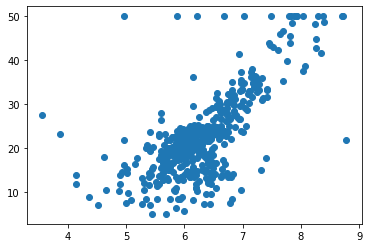

In [ ]:
x = np.array(data['rooms']).reshape(-1,1)
y = np.array(data['cmedv']).reshape(-1,1)
plt.scatter(x,y)

In [ ]:
# we want to split the data into a train/test set and we want to standardize correctly
xtrain, xtest, ytrain, ytest = tts(x,y,test_size=0.25, random_state=123)

Code to create a plot of x vs. y with the y-hat values superimposed:

In [ ]:
dat = np.concatenate([xtrain,ytrain.reshape(-1,1)], axis=1)

# this is sorting the rows based on the first column
dat = dat[np.argsort(dat[:, 0])]

dat_test = np.concatenate([xtest,ytest.reshape(-1,1)], axis=1)
dat_test = dat_test[np.argsort(dat_test[:, 0])]
Yhat_lowess = lowess_kern(dat[:,0],dat[:,1],Epanechnikov,0.6)
datl = np.concatenate([dat[:,0].reshape(-1,1),Yhat_lowess.reshape(-1,1)], axis=1)
f = interp1d(datl[:,0], datl[:,1],fill_value='extrapolate')

yhat = f(dat_test[:,0])

Text(0.5, 1.0, 'Boston Housing Prices')

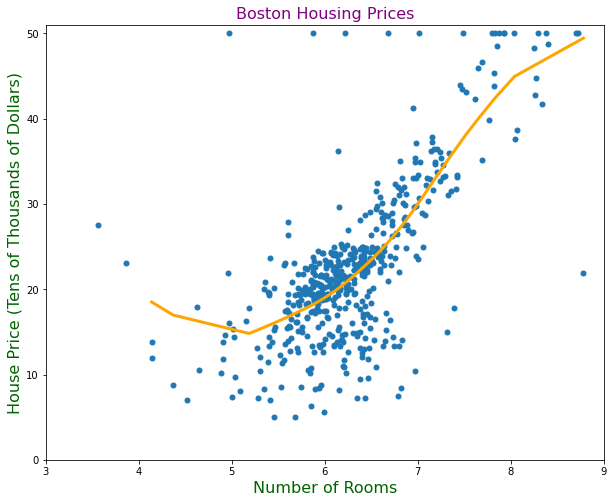

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(3, 9)
ax.set_ylim(0, 51)
ax.scatter(x=data['rooms'], y=data['cmedv'],s=25)
ax.plot(dat_test[:,0], yhat, color='orange',lw=3)
ax.set_xlabel('Number of Rooms',fontsize=16,color='Darkgreen')
ax.set_ylabel('House Price (Tens of Thousands of Dollars)',fontsize=16,color='Darkgreen')
ax.set_title('Boston Housing Prices',fontsize=16,color='purple')

In [ ]:
x = data['rooms'].values
y = data['cmedv'].values

In [ ]:
xtrain, xtest, ytrain, ytest = tts(x,y,test_size=0.25, random_state=123)

Applying locally weighted regression to the Boston Housing Data Set:

In [ ]:
scale = StandardScaler()
xtrain_scaled = scale.fit_transform((xtrain).reshape(-1,1))
xtest_scaled = scale.transform((xtest).reshape(-1,1))

In [ ]:
yhat_test = lowess_reg(xtrain_scaled.ravel(),ytrain,xtest_scaled,tricubic,0.1)

In [ ]:
mse(yhat_test,ytest)

43.818769754447246

Applying Random Forest Regression to the Boston Housing Data Set:

In [ ]:
rf = RandomForestRegressor(n_estimators=100,max_depth=3)

In [ ]:
rf.fit(xtrain_scaled,ytrain)

RandomForestRegressor(max_depth=3)

In [ ]:
mse(ytest,rf.predict(xtest_scaled))

44.06947431480829

In [ ]:
yhat_test = lowess_reg(xtrain_scaled.ravel(),ytrain,xtest_scaled.ravel(),tricubic,0.1)

Calculating crossvalidated mean squared error for both methods:

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=310)
mse_lwr = []
mse_rf = []

In [ ]:
rf = RandomForestRegressor(n_estimators=100,max_depth=3)

In [ ]:
mse_lwr = []
mse_rf = []

for idxtrain,idxtest in kf.split(x):
  ytrain = y[idxtrain]
  xtrain = x[idxtrain]
  xtrain = scale.fit_transform(xtrain.reshape(-1,1))
  ytest = y[idxtest]
  xtest = x[idxtest]
  xtest = scale.transform(xtest.reshape(-1,1))
  yhat_lwr = lowess_reg(xtrain.ravel(),ytrain,xtest.ravel(),tricubic,0.5)
  rf.fit(xtrain,ytrain)
  yhat_rf = rf.predict(xtest)
  mse_lwr.append(mse(ytest,yhat_lwr))
  mse_rf.append(mse(ytest,yhat_rf))

In [ ]:
np.mean(mse_lwr)

36.6550430330479

In [ ]:
np.mean(mse_rf)

35.881965942428394

The random forest regression model has a lower MSE and therefore achieved better results.